In [4]:
import polars as pl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import sqrt, dot
import seaborn as sns
from kennard_stone import train_test_split

In [5]:
sns.set_theme()

In [6]:
def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):
    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame):
    return (((y_hat - y_obs.to_series())**2).sum()/y_obs.shape[0])**0.5

def F(y_pred: pl.Series, y_obs: pl.DataFrame, descriptor_number: int):
    return (((y_pred - y_pred.mean())**2).sum() / (y_pred.shape[0] - 1)) / (((y_obs.to_series() - y_pred)**2).sum() / (y_pred.shape[0] - descriptor_number - 1))

In [7]:
dane_leki = pl.read_excel(
                source="dane_leki.xlsx",
                columns=list(range(1,7))
).sort(pl.col("logK HSA"))

In [8]:
dane_leki

Nazwa,logK HSA,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
str,f64,f64,i64,i64,i64
"""metronidazole""",-1.25,-0.97,2,0,6
"""acyclovir""",-1.25,-0.11,3,0,6
"""zidovudine""",-1.25,-0.43,3,0,7
"""acetaminophen""",-0.79,-0.63,2,0,2
"""famotidine""",-0.77,0.01,4,1,5
…,…,…,…,…,…
"""diclofenac""",1.69,1.98,0,1,3
"""indomethacin""",1.82,1.63,1,4,5
"""ibuprofen""",1.84,0.73,0,5,2


In [9]:
Y = dane_leki.select(pl.col('Nazwa'), pl.col("logK HSA"))

In [10]:
Y

Nazwa,logK HSA
str,f64
"""metronidazole""",-1.25
"""acyclovir""",-1.25
"""zidovudine""",-1.25
"""acetaminophen""",-0.79
"""famotidine""",-0.77
…,…
"""diclofenac""",1.69
"""indomethacin""",1.82
"""ibuprofen""",1.84


In [11]:
X = dane_leki.select(
    pl.exclude(["logK HSA", "Zbiór"])
)

In [12]:
X

Nazwa,logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
str,f64,i64,i64,i64
"""metronidazole""",-0.97,2,0,6
"""acyclovir""",-0.11,3,0,6
"""zidovudine""",-0.43,3,0,7
"""acetaminophen""",-0.63,2,0,2
"""famotidine""",0.01,4,1,5
…,…,…,…,…
"""diclofenac""",1.98,0,1,3
"""indomethacin""",1.63,1,4,5
"""ibuprofen""",0.73,0,5,2


In [14]:
X_trening, X_walidacja, Y_trening, Y_walidacja = train_test_split(X.select(pl.exclude("Nazwa")), Y.select(pl.exclude("Nazwa")), test_size=0.3)

Calculating pairwise distances using scikit-learn.
Calculating pairwise distances using scikit-learn.


In [16]:
X_walidacja

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
0.57,0,0,2
0.3,2,0,2
1.25,1,3,3
0.68,0,0,3
1.25,0,0,3
-0.11,3,0,6
0.57,1,0,3
0.01,4,1,5
1.5,0,0,2


In [17]:
Y_walidacja

logK HSA
f64
0.67
0.2
1.42
0.69
1.08
-1.25
0.38
-0.77
1.18


In [18]:
X_trening

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,i64,i64,i64
0.73,1,0,1
-0.63,3,0,5
-0.97,2,0,6
0.26,2,0,1
1.09,0,3,6
…,…,…,…
-0.43,3,0,7
1.32,3,2,5
1.98,0,1,3


In [19]:
Y_trening

logK HSA
f64
1.39
-0.6
-1.25
-0.42
0.06
…
-1.25
0.08
1.69


In [20]:
corr_matrix = X.select(
    pl.exclude("Nazwa")
).corr()

In [21]:
corr_matrix

logKCTAB,CATS3D_00_DD,CATS3D_09_AL,CATS3D_00_AA
f64,f64,f64,f64
1.0,-0.633481,0.446144,-0.135951
-0.633481,1.0,-0.291248,0.290864
0.446144,-0.291248,1.0,0.326375
-0.135951,0.290864,0.326375,1.0


In [22]:
linear_model = LinearRegression().fit(X_trening, Y_trening)

In [23]:
linear_model.coef_

array([[ 0.53651302, -0.13824279,  0.32029191, -0.18554739]])

In [24]:
linear_model.intercept_

array([0.44488329])

In [25]:
pred_Y_trening = pl.Series(linear_model.predict(X_trening).reshape(-1))
pred_Y_walidacja = pl.Series(linear_model.predict(X_walidacja).reshape(-1))

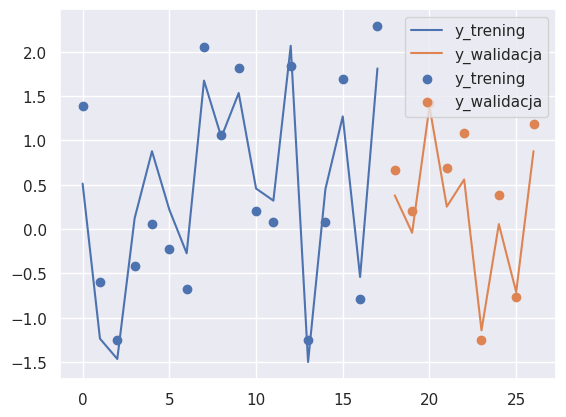

In [26]:
plt.plot(range(X_trening.shape[0]), pred_Y_trening, label="y_trening")
plt.plot(range(X_trening.shape[0], X_trening.shape[0] + X_walidacja.shape[0]),pred_Y_walidacja, label="y_walidacja")
plt.scatter(range(Y_trening.shape[0]), Y_trening, label="y_trening")
plt.scatter(range(Y_trening.shape[0], Y_trening.shape[0] + Y_walidacja.shape[0]), Y_walidacja, label="y_walidacja")
plt.legend()

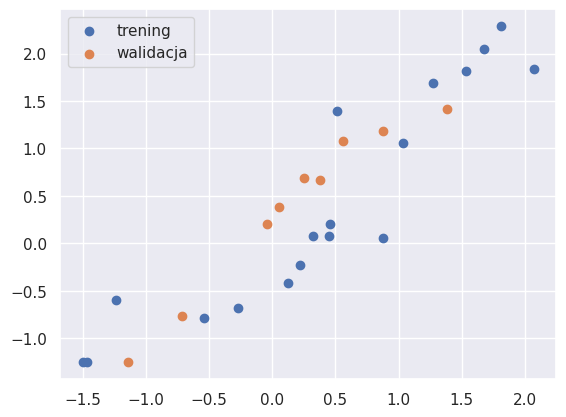

In [27]:
plt.scatter(pred_Y_trening, Y_trening, label="trening")
plt.scatter(pred_Y_walidacja, Y_walidacja, label="walidacja")
plt.legend()

In [28]:
h_i_trening = pl.Series(
    dot(

        dot(

            pl.Series(X_trening.cast(pl.Float64).row(i)).reshape((1,-1)), 
            inv(
                dot(

                    X_trening.cast(pl.Float64).transpose(), 
                    X_trening.cast(pl.Float64)
                    
                )
            )

        ),
        pl.Series(X_trening.cast(pl.Float64).row(i))

    )[0] for i in range(X_trening.shape[0])
)

In [29]:
h_i_trening.head(5)

""
f64
0.09414
0.213174
0.312989
0.155835
0.194567


In [30]:
h_i_walidacja = pl.Series(
    dot(

        dot(

            pl.Series(X_walidacja.cast(pl.Float64).row(i)).reshape((1,-1)), 
            inv(
                dot(

                    X_walidacja.cast(pl.Float64).transpose(), 
                    X_walidacja.cast(pl.Float64)
                    
                )
            )

        ),
        pl.Series(X_walidacja.cast(pl.Float64).row(i))

    )[0] for i in range(X_walidacja.shape[0])
)

In [31]:
h_i_walidacja.head(5)

""
f64
0.123123
0.426238
0.951998
0.320391
0.315566


In [32]:
h_star = 3*(X_trening.shape[1]) / X_trening.shape[0]

In [33]:
trening_residuals = Y_trening - pred_Y_trening
stan_trening_residuals = trening_residuals.select((pl.col("logK HSA") - trening_residuals.mean()) / trening_residuals.std())

walidacja_residuals = Y_walidacja - pred_Y_walidacja
stan_walidacja_residuals = walidacja_residuals.select((pl.col("logK HSA") - walidacja_residuals.mean()) / walidacja_residuals.std())

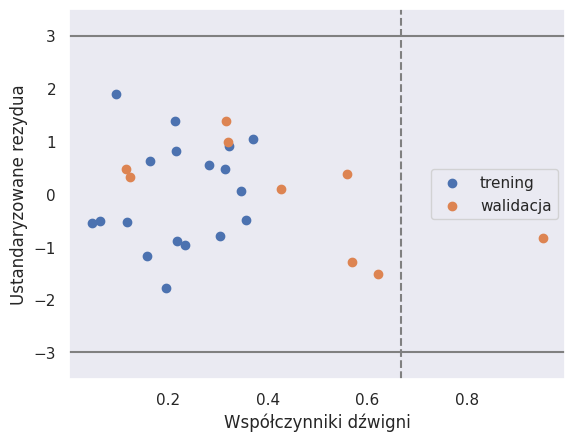

In [34]:
plt.scatter(h_i_trening, stan_trening_residuals, label="trening")
plt.scatter(h_i_walidacja, stan_walidacja_residuals, label="walidacja")
plt.axvline(h_star, linestyle="dashed", color="grey")
plt.axhline(-3, color='grey')
plt.axhline(3, color='grey')
plt.grid()
plt.ylim(-3.5,3.5)
plt.xlabel("Współczynniki dźwigni")
plt.ylabel("Ustandaryzowane rezydua")
plt.legend()

In [35]:
R2(pred_Y_trening, Y_trening)

0.8488840411293017

In [36]:
RMSE(pred_Y_trening, Y_trening)

0.4481301257715681

In [37]:
RMSE(pred_Y_walidacja, Y_walidacja)

0.3014598156031032

In [38]:
pred_Y_cv = pl.Series([LinearRegression()
    .fit(
        X_trening.with_row_index().filter(pl.col('index') != i).drop('index'),
        Y_trening.with_row_index().filter(pl.col('index') != i).drop('index')
    )
    .predict(
        X_trening.with_row_index().filter(pl.col('index') == i).drop('index')
    )[0][0] for i in range(X_trening.shape[0])] 
    )

In [39]:
Q2(pred_Y_cv, Y_trening)

0.7252418313545901

In [40]:
RMSE(pred_Y_cv, Y_trening)

0.6042606053843852

In [41]:
ex_model = LinearRegression().fit(X_trening, Y_trening)

In [42]:
pred_Y_ex = pl.Series(ex_model.predict(X_walidacja).reshape(-1))

In [43]:
Q2(pred_Y_ex, Y_walidacja)

0.8722027837795137

In [44]:
RMSE(pred_Y_ex, Y_walidacja)

0.3014598156031032

In [45]:
F(pred_Y_trening, Y_trening, 4)

4.295685409656527